# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [1]:
# Install needed packages
!pip install gensim

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# import needed packages
import pandas as pd
import numpy as np
import logging
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Omri
[nltk_data]     Allouche\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Omri
[nltk_data]     Allouche\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
STOP_WORDS = set(stopwords.words('english'))
PUNCT = dict.fromkeys(map(ord, string.punctuation))

In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

c:\programdata\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
df = pd.read_csv('data/lyrics.csv', index_col=0)
print('df.shape:', df.shape)
print('df.columns:', df.columns)
df.head()

df.shape: (362237, 5)
df.columns: Index(['song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [7]:
df = df.dropna().reset_index(drop=True)

### Exploratory Data Analysis
Let's examine the data a bit first. We can print the numbers, or plot a bar chart of the counts.

In [8]:
df.groupby('genre')['lyrics'].count().sort_values()

genre
Folk               2243
Indie              3149
R&B                3401
Other              5189
Electronic         7966
Jazz               7970
Country           14387
Metal             23759
Not Available     23941
Hip-Hop           24850
Pop               40466
Rock             109235
Name: lyrics, dtype: int64

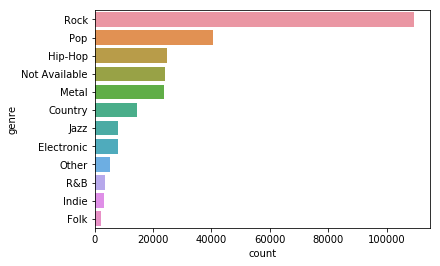

In [9]:
sns.countplot(data=df, y='genre', order=df.groupby('genre')['lyrics'].count().sort_values(ascending=False).index, orient='h')

We see that there are a lot of Rock songs, and very few Indie and Folk songs. How can this class imbalance affect our classifier performance?

This class imbalance might affect our algorithms if we're using only the most common words, since these words will be biased by their prevalance in Rock and Pop songs. Furthermore, it might prefer to minimize errors in the common classes over those in rare classes, and so possibly even learn to classify any song as "Rock" simply because it wasn't incentivized enough to learn other classes.

We see that some songs are classified as "Not Available" or "Other". We should probably remove these from our dataset:

In [10]:
df = df[ ~df.genre.isin(['Not Available', 'Other'])]

Next, let's examine the distribution of the length of songs. We expect most songs to be around 3-5 minutes, and therefore have a certain length.

In [11]:
df['num_chars'] = df['lyrics'].str.len()

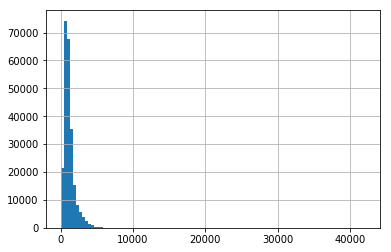

In [12]:
df['num_chars'].hist(bins=100)

We see a large pick at roughly 1000 characters, but a long tail of long documents, and quite a few documents that are very short. Let's check the CDF (Comulative Distribution Function):

In [13]:
from scipy.stats import percentileofscore, scoreatpercentile
from numpy import sort, arange, nanpercentile, diff

def get_cdf(data, ignore_nan=False):
    if ignore_nan:
        data = data[ ~np.isnan(data) ]
    values = sort(data)
    percentiles = arange(len(values))/float(len(values))
    return values, percentiles

def plot_cdf(data, **kwargs):
    ignore_nan = kwargs.pop('ignore_nan', False)
    ax = kwargs.pop('ax', plt.gca())
    values, percentiles = get_cdf(data, ignore_nan=ignore_nan)
    ax.plot(values, percentiles, **kwargs )
    return values, percentiles

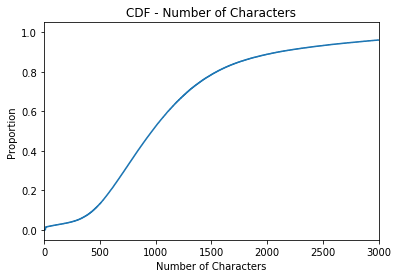

In [14]:
plot_cdf(df['num_chars']);
plt.xlim((0, 3000))
plt.xlabel('Number of Characters'); plt.ylabel('Proportion'); plt.title('CDF - Number of Characters');

We indeed see that some documents are very short (remember this is the number of characters, including spaces, punctuation marks and new line characters). We will examine the short and long documents later.

Next, let's examine the length of songs by genre, using a box plot:

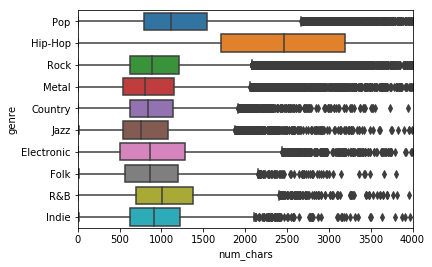

In [15]:
sns.boxplot(data=df, y='genre', x='num_chars')
plt.xlim(0, 4000);

We see that Hip-Hop songs tend to be much longer than the others, but don't see very large differences between other genres. We also note that there are many songs that are very long.

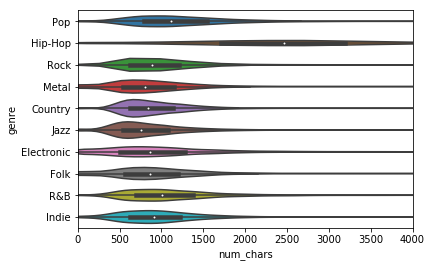

In [16]:
sns.violinplot(data=df, y='genre', x='num_chars')
plt.xlim(0, 4000);

We see that Electronic and Pop songs have large variability in length compared with Jazz and Country.

Next, let's examine the longest documents:

In [17]:
df.sort_values('num_chars').tail(20)

,song,year,artist,genre,lyrics,num_chars
133487,crimson-ii-incantation,2006,edge-of-sanity,Metal,Let no man breach the gate to this most blasph...,12840
133472,crimson-ii,2007,edge-of-sanity,Metal,[I - The forbidden words]\n[II - Incantation]\...,13042
108347,rip-vs-poet-laurette,2012,canibus,Hip-Hop,[Intro: 'Gladiator' sample]\nYou have proved y...,13048
121890,alice-s-restaurant,2007,arlo-guthrie,Rock,[CHORUS:]\nYou can get anything you want at Al...,13100
126363,magica,2000,dio,Rock,It has been a thousand years since the once po...,13102
126366,magica-the-story,2000,dio,Rock,It has been a thousand years since the once po...,13114
247745,billy-the-mountain,2006,frank-zappa,Rock,Mark volman (lead vocals)\nHoward kaylan (lead...,13134
173979,into-the-woods-prologue-act-i,2014,broadways,Rock,NARRATOR\nOnce upon a time\nCINDERELLA\nI wish...,13164
122009,alice-s-restaurant-massacre,1990,arlo-guthrie,Rock,You can get anything you want at Alice's Resta...,13841
255129,because-the-internet-screenplay-part-4,2013,childish-gambino,Hip-Hop,"[VISUAL PLAYING ""DEATH BY NUMBERS""]\n*******[P...",15006


Let's examine a few of the records with many characters. We can see that these aren't actually songs - they are, for example, interviews or full albums. We don't expect our classifier to classify these correctly or learn from them, and better remove them from our corpus.

In [18]:
print( df.loc[255126].lyrics )

CUT TO:
*******[PLAY SONG "DIAL UP" AT THIS POINT]*******
[VISUAL]
The Boy lies, arms to his side, on his bed, looking at the ceiling
Spiders slowly drop from single strands of web from all the posts on the bed. It looks pretty. All of them dropping simultaneously swaying together. They whisper:
......where are you?
................who is this?
...don't slide
It's almost a song
*******[PLAY SONG "THE WORST GUYS" AT THIS POINT]*******
INT. MANSION - NIGHT
More people are at the house. People drinking and smoking. Shoes off. It's a Temple. Respect it
The back wall of the living room has been pushed into the wall, so there's a seamless transiting from living room to backyard patio
People sit on the swings underneath space heaters
EMILY is in the middle of the pool table. Swank plays pool around her. RUBEN is filming Marcus and Steve throwing things in the fire pit
AJ is djing in the middle of the living room
Some guy is running through the living room in just a towel. He is dripping water

In [19]:
print( df.loc[230543].lyrics )

Zane Lowe: Welcome back to Radio One, Maida Vale studio 4 here we are. Part of the reason we're here obviously because its the BBC but also because we have Studio 3 around the corner and you've got the band set up and going to perform some songs as well.
Eminem: It's super exciting to be here. I was trying to figure out how I was going to top the publicity of yours and Kanye's interview so I decided I was going to walk in here, pee on the floor, and leave. I'm peeing right now. Alright see you guys later!
ZL: Seeing you with the band, and seeing you perform the other night at the awards show and seeing you on the mic, it was, I don't think I've ever seen you more alive on the mic. It was full of energy and in the moment. What I noticed was as well was spitting live with the band behind you seemed to free you up a lot more. Are you feeling that way?
E: I think performing has gotten a lot different, it's gotten better with the band because there's just more elements to it and being it is

In [20]:
print( df.query('num_chars>4000 & num_chars<4500').iloc[2]['lyrics'] )

Hey yo man, remember that shit Eazy did a while back
Motherfuckers said it wasn't gonna work
That crazy shit, yeah the stupid shit
Hey yo Eazy! (Yo!)
Hey man why don't you come off the piano for a minute
And bust this crazy shit
Woke up quick at about noon
Just thought that I had to be in Compton soon
I gotta get drunk before the day begins
Before my mother starts bitchin' about my friends
About to go and damn near went blind
Young niggaz at the pad throwin' up gang signs
Ran in the house and grabbed my clip
With the Mac-10 on the side of my hip
Bailed outside and pointed my weapon
Just as I thought, the fools kept steppin'
Jumped in the fo' hit the juice on my ride
I got front back and side to side
Then I let the Alpine play
Bumpin' new shit by NWA
It was "Gangsta Gangsta" at the top of the list
Then I played my own shit, it went somethin' like this
Cruisin' down the street in my six-fo'
Jockin' the bitches, slappin' the hoes
Went to the park to get the scoop
Knuckleheads out there co

On the other end, let's examine a few of the short songs in our dataset:

In [21]:
df.sort_values('num_chars').head(100)

,song,year,artist,genre,lyrics,num_chars
165156,nii-ie-i-ai,2006,edaiaoidee,Rock,",",1
4678,dd-ndu-d1-2dud-ddeg,2013,ddoduddegd1-2-dd-nd-d,Rock,',1
6534,aeoa,2006,adaaeaaineay-iaidiia,Rock,-,1
6523,oidioee-aaoiaon,2006,adaaeaaineay-iaidiia,Rock,",",1
6507,iida-eii-aou,2006,adaaeaaineay-iaidiia,Rock,-,1
6476,ndaae-cadaaeaiiiai-eiaeeie-ieda,2006,adaaeaaineay-iaidiia,Rock,",",1
6463,eae-oi-oodii-ia-dannaaoa,2006,adaaeaaineay-iaidiia,Rock,-,1
165221,aiaae,2006,edaiaoidee,Rock,",",1
165151,aiadiiaaa,2006,edaiaoidee,Rock,",",1
165204,inaiu,2006,edaiaoidee,Rock,",",1


We see that many songs have only special characters and no actual lyrics. We also see comments in [] blocks. We'd like to make sure we remove these from our data.

In [22]:
df = df[ df['num_chars']>100 ]

### Sample data 
In order to explore efficiently, we don't need all of the data we have. Let's create a subset of it, making sure the number of songs from each category generally matches. 

We first focus only on the most common genres - Rock, Pop, Hip-Hop, Metal and Country.

In [23]:
df = df[ df.genre.isin(['Rock', 'Pop', 'Hip-Hop', 'Metal', 'Country'])]
genre_counts = df['genre'].value_counts()

In [24]:
weights = [ 1/genre_counts.loc[v] for v in df.genre.values ]

In [25]:
s = df.sample(n=50000, random_state=10, weights=weights)

In [26]:
s.genre.value_counts()

Rock       11742
Pop        10809
Hip-Hop     9730
Metal       9445
Country     8274
Name: genre, dtype: int64

Let's process the lyrics and save the result in a Parquet file.

In [27]:
import string
import nltk
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
PUNCT = dict.fromkeys(map(ord, string.punctuation))

def nltk_tokenize(text):
    text = re.sub("[^a-zA-Z]"," ", text) # keep only english letters
    text = re.sub("[\[*\]]"," ", text) # replace consecutive spaces with a single space
    text = text.translate(PUNCT) # remove punctuation marks
    return " ".join([word.lower() for word in nltk.word_tokenize(text) if word not in STOP_WORDS])

In [28]:
print( df.iloc[0].lyrics )

Oh baby, how you doing?
You know I'm gonna cut right to the chase
Some women were made but me, myself
I like to think that I was created for a special purpose
You know, what's more special than you? You feel me
It's on baby, let's get lost
You don't need to call into work 'cause you're the boss
For real, want you to show me how you feel
I consider myself lucky, that's a big deal
Why? Well, you got the key to my heart
But you ain't gonna need it, I'd rather you open up my body
And show me secrets, you didn't know was inside
No need for me to lie
It's too big, it's too wide
It's too strong, it won't fit
It's too much, it's too tough
He talk like this 'cause he can back it up
He got a big ego, such a huge ego
I love his big ego, it's too much
He walk like this 'cause he can back it up
Usually I'm humble, right now I don't choose
You can leave with me or you could have the blues
Some call it arrogant, I call it confident
You decide when you find on what I'm working with
Damn I know I'm kil

In [29]:
nltk_tokenize( df.iloc[0].lyrics )

'oh baby you know i gon na cut right chase some women made i like think i created special purpose you know special you feel it baby let get lost you need call work cause boss for real want show feel i consider lucky big deal why well got key heart but gon na need i rather open body and show secrets know inside no need lie it big wide it strong fit it much tough he talk like cause back he got big ego huge ego i love big ego much he walk like cause back usually i humble right i choose you leave could blues some call arrogant i call confident you decide find i working damn i know i killing legs better yet thighs matter fact smile maybe eyes boy site see kind something like it big wide it strong fit it much tough i talk like cause i back i got big ego huge ego but love big ego much i walk like cause i back i i walk like cause i back i i talk like cause i back i i back i back i walk like cause i back it big wide it strong fit it much tough he talk like cause back he got big ego huge ego hug

In [30]:
df['sent'] = df['lyrics'].apply(nltk_tokenize)

In [31]:
df['num_words'] = df.sent.apply(lambda x: len(x))
df = df[ df.num_words > 5]

In [33]:
df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",1961,oh baby you know i gon na cut right chase some...,1145
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",1270,playin everything easy like seem sure still wa...,679
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,827,if search for tenderness it hard find you love...,643
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",2344,oh oh oh i oh oh oh i verse if i wrote book st...,1502
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",1540,party people people party popping sitting arou...,947


In [36]:
# conda install pyarrow -c conda-forge -y
df.to_parquet('lyrics.parquet')

We can move on to the next notebooks now!